# Interval SA

Attempt interval SA with the Ishigami function.

In [100]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.patches as patches
import qmcpy as qp

In [101]:
def ishigami(x):
    return (
        np.sin(x[:, 0])
        + 5 * (np.sin(x[:, 1]) ** 2)
        + 0.1 * np.sin(x[:, 0]) * x[:, 2] ** 4
    )


# Generate samples
# x1, x2, x3 within [-pi, pi]
# n = 2000
n_params = 3
# rng = np.random.default_rng()
# x = rng.uniform(low=-np.pi, high=np.pi, size=(n, n_params))

# Use Sobol sampling
sampler = qp.Sobol(dimension=n_params)
# True measure
# Bounds are bounds on individual parameters
true_measure = qp.Uniform(
    sampler=sampler,
    lower_bound=-np.pi,
    upper_bound=np.pi,
)

# Model evaluation
x = true_measure.gen_samples(n=2**13)

y = ishigami(x)

df = pd.DataFrame(
    data=(np.concat((x, y[:, np.newaxis]), axis=1)), columns=("x1", "x2", "x3", "y")
)
df

,x1,x2,x3,y
0,1.177719,-2.086756,-3.003758,12.226483
1,-2.065948,2.047654,2.473046,-0.224498
2,2.940386,1.313466,1.006170,4.896483
3,-0.297378,-1.274317,-1.334384,4.187312
4,0.677655,2.735984,-0.513044,1.409773
...,...,...,...,...
8187,-0.770120,-3.028503,0.263025,-0.632880
8188,0.217953,0.980850,0.983132,3.688993
8189,-2.827294,-0.825165,-1.342134,2.289164
8190,1.983441,-1.753432,-3.008377,13.254465


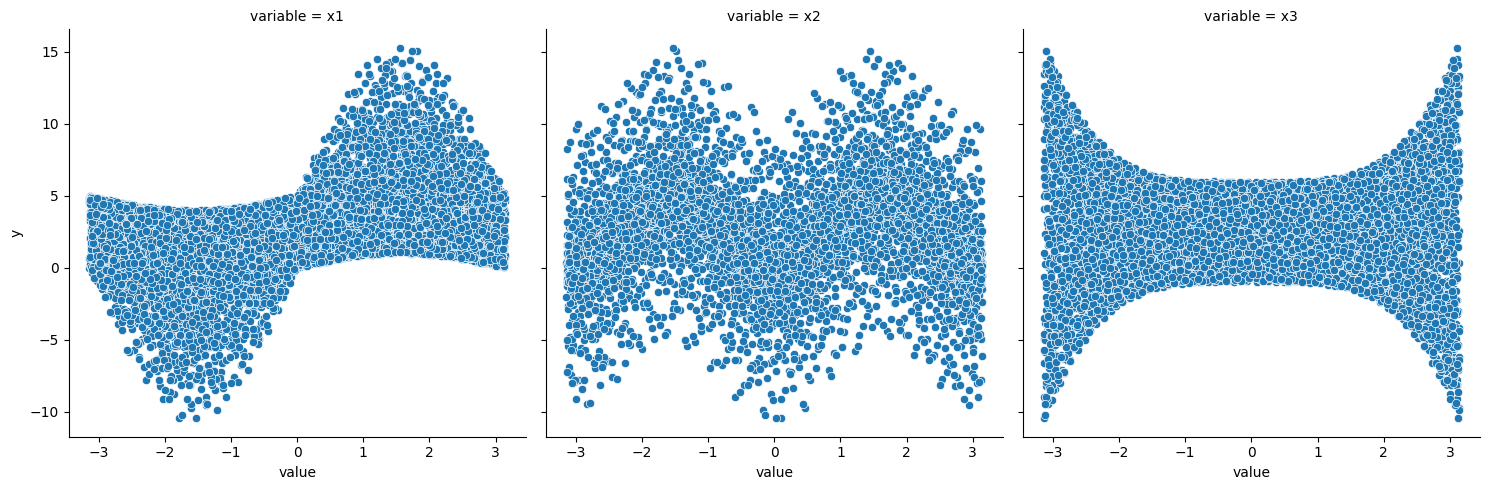

In [102]:
fg = sns.relplot(data=df.melt(id_vars="y"), x="value", y="y", col="variable")

Now plot output width in subintervals.

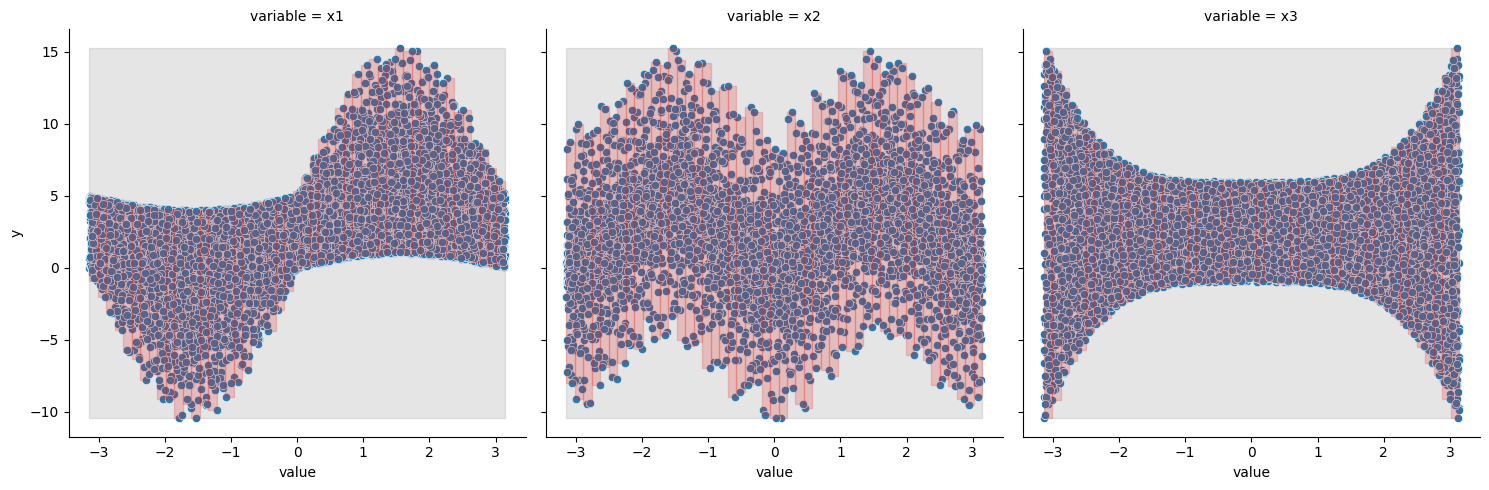

In [103]:
# Number of subintervals
n_subints = 50

# Divide param range into subintervals
# subints: (n_subints x n_params)
subints = np.linspace(x.min(axis=0), x.max(axis=0), n_subints)

y_ints_list = []
# TODO Could this be vectorised?
for param_idx in range(n_params):
    y_ints_list_param = []
    # Find y values in each subinterval
    for subint_idx in range(n_subints - 1):
        # Find y values using boolean array of xs in subinterval
        y_in_subint = y[
            (subints[subint_idx, param_idx] <= x[:, param_idx])
            & (x[:, param_idx] <= subints[subint_idx + 1, param_idx])
        ]
        y_ints_list_param.append([y_in_subint.min(), y_in_subint.max()])

    y_ints_list.append(y_ints_list_param)

# y_ints: (n_params x n_subints - 1 x 2)
# TODO Possible to create in correct shape, so I don't need to transform later?
y_ints = np.array(y_ints_list)


# Plot
# TODO Remove duplicate loops from above?
for param_idx in range(n_params):
    for subint_idx in range(n_subints - 1):
        rect = patches.Rectangle(
            xy=(subints[subint_idx, param_idx], y_ints[param_idx, subint_idx, 0]),
            width=(subints[subint_idx + 1, param_idx] - subints[subint_idx, param_idx]),
            height=(
                y_ints[param_idx, subint_idx, 1] - y_ints[param_idx, subint_idx, 0]
            ),
            edgecolor="r",
            linewidth=1,
            facecolor="r",
            alpha=0.2,
        )
        ax = fg.axes.flatten()[param_idx]
        ax.add_patch(rect)

    # Add box for entire interval
    rect = patches.Rectangle(
        xy=(subints[:, param_idx].min(), y_ints[param_idx, :, 0].min()),
        width=(subints[:, param_idx].max() - subints[:, param_idx].min()),
        height=(y_ints[param_idx, :, 1].max() - y_ints[param_idx, :, 0].min()),
        edgecolor="grey",
        linewidth=1,
        facecolor="grey",
        alpha=0.2,
    )
    ax = fg.axes.flatten()[param_idx]
    ax.add_patch(rect)

fg.figure

Now calculate sensitivity indices.

In [104]:
# Difference between subinterval bounds
# indices = np.sum(
#     (subints[1:, :] - subints[:-1, :]) * (y_ints[:, :, 1] - y_ints[:, :, 0]).T
# axis=0) / (
#     (y_ints[:, :, 1].max(axis=1) - y_ints[:, :, 0].min(axis=1))
#     * (subints[-1, :] - subints[0, :])
# )
# indices

# Split calculation from above for debugging
subint_diffs = subints[1:, :] - subints[:-1, :]
y_int_diffs = (y_ints[:, :, 1] - y_ints[:, :, 0]).T
y_box = y_ints[:, :, 1].max(axis=1) - y_ints[:, :, 0].min(axis=1)
x_box = subints[-1, :] - subints[0, :]
indices = 1 - np.sum(subint_diffs * y_int_diffs, axis=0) / (y_box * x_box)
indices

array([0.5815753 , 0.26971387, 0.57567737])

Interval-arithmetic results: [0.568, 0.181, 0.581]

The sampling-based results above over-estimate the indices due to underestimating the min and max in each subinterval (sampling is an inner approximation to interval arithmetic). $x_2$ is particularly mis-represented in the indices; this can be seen by the non-smooth subinterval boxes in its plot. The sampling method can be made to better represent the true area of the function by increasing samples (preferred) or by increasing subinterval size (risks over-estimating area, then under-estimating index). Try increasing samples.

The indices add to more than 1 because the interactions are taken into account but double counted, unlike in the Sobol indices.

In [105]:
# Compare with paper results (interval arithmetic)
paper_indices = np.array([0.568, 0.181, 0.581])
# 50 subintervals, different samples
samples_2048 = np.array([0.61561636, 0.39467074, 0.58763784])
samples_4096 = np.array([0.57069545, 0.27585842, 0.56204769])
samples_8192 = np.array([0.57557061, 0.25081495, 0.57137354])
print(f"{samples_2048 - paper_indices = }")
print(f"{samples_4096 - paper_indices = }")
print(f"{samples_8192 - paper_indices = }")

samples_2048 - paper_indices = array([0.04761636, 0.21367074, 0.00663784])
samples_4096 - paper_indices = array([ 0.00269545,  0.09485842, -0.01895231])
samples_8192 - paper_indices = array([ 0.00757061,  0.06981495, -0.00962646])


Generally, more samples (with narrow enough subintervals) gives good agreement between the sampling and interval arithmetic cases.